### PLACE ALL IMPORTS HERE (easier to keep track of)

In [2]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

In [3]:
source_dir = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\book-nlp-master\\book-nlp-master\\data\\originalTexts"
bookfile = open(source_dir + '\\full_hp.txt', 'r')
book = bookfile.read()
bookDict = defaultdict(float)
for word in book.split():
    bookDict[word] += 1
counter = Counter(bookDict)
top_n = counter.most_common(200)
print top_n
print

[('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so', 2241.0), ('this', 2197.0)

#### Paste in direct path to the JSON file (because the relative paths aren't working)

In [4]:
wk_dir = os.path.dirname(os.path.realpath('__file__'))

#json_filename = os.path.join(wk_dir, "..", "booknlp_output\\potter.all.book.txt")
json_filename = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\char-net\\booknlp_output\\book.id.book";

with open(json_filename) as json_file:
	char_json = json.load(json_file)
print "successfully loaded json"

successfully loaded json


#### Load stopwords list, combine it with NLTK's English stopwords list (add words to list as needed)

In [14]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(stemmer.stem(token))
    return filtered_tokens

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
curDir = os.path.dirname(os.path.realpath('__file__'))
stop = os.path.join(curDir,'stopwords')     
stopfile = open(stop, 'r')
stop = stopfile.read()
for word in stop.split():
    stopwords.extend(tokenize_and_stem(word))
# take this out if necessary? just seeing if throwing out the top words improves results
for word in top_n:
    stopwords.extend(tokenize_and_stem(word[0].decode("utf8").lower()))   
print stopwords
stopwords = set(stopwords)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

#### Create character feature vectors (TODO: ADD IN DIALOGUE FEATURES HERE)

In [73]:
# dictionary of lists of character attributes, indexed by name (i.e. character's "bag of words")
characters = {}
character_namelists = {}
total_features = defaultdict(float)

for character in char_json["characters"]:
    # TODO: throw out characters that are mentioned less than 10 times (play with this threshold?)
    if character["NNPcount"] > 20:
        #changed this to be the full list of names rather than the first one
        namelist = [character["names"][i]['n'] for i in range(len(character["names"]))]
        char_name = character["names"][0]['n']
        #store character's full list of names for later use
        character_namelists[char_name] = namelist
        
        #create feature vector for that character
        characters[char_name] = []
        for word_dict in character["patient"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_PATIENT")
                total_features[curWord[0] + "_PATIENT"] += 1
        for word_dict in character["agent"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_AGENT")
                total_features[curWord[0] + "_AGENT"] += 1
        for word_dict in character["mod"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_MOD")
                total_features[curWord[0] + "_MOD"] += 1
                
        #TODO: add dialogue features?
        for word_dict in character['speaking']:
            curPhrase = word_dict['w']
            spoken_words = tokenize_and_stem(curPhrase)
            for word in spoken_words:
                if word not in stopwords:
                    characters[char_name].append(word + "_SAY")
                    total_features[word + "_SAY"] += 1
                
        # are things characters possess indicative of their character? Often not, so maybe exclude
        for word_dict in character["poss"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_POSS")
                total_features[curWord[0] + "_POSS"] += 1

texts = [None for i in range(len(characters))]
names = defaultdict(float)
i = 0
for key, value in characters.iteritems():
	print str(key) + ": " + str(value)
	texts[i] = value
	names[key] = i
	i += 1
	print

Madam Rosmerta: [u'forc_PATIENT', u'gasp_PATIENT', u'breath_PATIENT', u'stare_AGENT', u'fill_AGENT', u'eject_wizard_AGENT', u'totter_AGENT', u'send_bottl_AGENT', u'have_oth_AGENT', u'tip_you_AGENT', u'help__AGENT', u'admit_AGENT', u'let_sigh_AGENT', u'abl_MOD', u'stay_SAY', u'black_SAY', u'area_SAY', u'minist_SAY', u'dementor_SAY', u'search_SAY', u'whole_SAY', u'villag_SAY', u'twjce_SAY', u'worst_SAY', u'wors_SAY', u'murder_SAY', u'poor_SAY', u'mean_SAY', u'natur_SAY', u'black_SAY', u'leagu_SAY', u'doe_SAY', u'work_SAY', u'black_SAY', u'potter_SAY', u'secret-keep_SAY', u'suspect_SAY', u'black_SAY', u'black_SAY', u'betray_SAY', u'manag_SAY', u'disappear_SAY', u'ministri_SAY', u'magic_SAY', u'caught_SAY', u'next_SAY', u'day_SAY', u'pettigrew_SAY', u'fat_SAY', u'boy_SAY', u'alway_SAY', u'tag_SAY', u'hogwart_SAY', u'black_SAY', u'taken_SAY', u'twenti_SAY', u'member_SAY', u'magic_SAY', u'law_SAY', u'enforc_SAY', u'squad_SAY', u'pettigrew_SAY', u'receiv_SAY', u'order_SAY', u'merlin_SAY', u'c

In [74]:
counter = Counter(total_features)
top_n = counter.most_common(200)
print top_n
print

[(u'oh_SAY', 398.0), (u'yes_SAY', 360.0), (u'stare_AGENT', 335.0), (u'yeah_SAY', 309.0), (u'potter_SAY', 296.0), (u'shoulder_POSS', 271.0), (u'good_SAY', 270.0), (u'tell__AGENT', 260.0), (u'stood_AGENT', 257.0), (u'walk_AGENT', 255.0), (u'sat_AGENT', 250.0), (u'whi_SAY', 249.0), (u'robe_POSS', 248.0), (u'hair_POSS', 220.0), (u'mean_SAY', 218.0), (u'thing_SAY', 215.0), (u'ear_POSS', 210.0), (u'mind_POSS', 205.0), (u'cours_SAY', 205.0), (u'doe_SAY', 196.0), (u'need_SAY', 193.0), (u'move_AGENT', 193.0), (u'ad_AGENT', 193.0), (u'year_SAY', 182.0), (u'magic_SAY', 173.0), (u'offic_POSS', 171.0), (u'sure_MOD', 169.0), (u'glanc_AGENT', 169.0), (u'dark_SAY', 165.0), (u'stand_AGENT', 165.0), (u'heart_POSS', 164.0), (u'start_AGENT', 164.0), (u'watch_PATIENT', 164.0), (u'sit_AGENT', 159.0), (u'yeh_SAY', 158.0), (u'ask__AGENT', 157.0), (u'sure_SAY', 156.0), (u'happen_SAY', 154.0), (u'hurri_AGENT', 148.0), (u'mother_POSS', 148.0), (u'bit_SAY', 148.0), (u'pocket_POSS', 146.0), (u'stop_AGENT', 144.0),

## Do LDA Topic Modeling Using Character Features

In [75]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 10

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce good results.

In [76]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [77]:
print(lda.show_topics())

[u'0.003*montagu_SAY + 0.003*visit_PATIENT + 0.002*bludger_SAY + 0.002*quaffl_SAY + 0.002*slytherin_SAY + 0.002*pocket_POSS + 0.002*bell_SAY + 0.002*friend_POSS + 0.002*hous_POSS + 0.002*sister_POSS', u'0.021*hollow_POSS + 0.008*master_SAY + 0.008*kreacher_SAY + 0.005*yes_SAY + 0.003*regulus_SAY + 0.003*tale_POSS + 0.002*croak_PATIENT + 0.002*oh_SAY + 0.002*fight_SAY + 0.002*lord_SAY', u'0.005*potter_SAY + 0.004*father_POSS + 0.003*mind_POSS + 0.003*do_what_AGENT + 0.003*name_POSS + 0.003*mother_POSS + 0.003*thing_SAY + 0.002*move_AGENT + 0.002*robe_POSS + 0.002*cloak_POSS', u'0.008*oh_SAY + 0.005*yes_SAY + 0.004*good_SAY + 0.004*doe_SAY + 0.003*yeah_SAY + 0.003*stare_AGENT + 0.003*whi_SAY + 0.003*mean_SAY + 0.003*tell__AGENT + 0.003*ad_AGENT', u'0.007*potter_SAY + 0.005*offic_POSS + 0.005*lord_SAY + 0.004*cage_POSS + 0.003*dark_SAY + 0.003*desk_POSS + 0.003*memori_POSS + 0.003*whi_SAY + 0.002*robe_POSS + 0.002*dear_SAY', u'0.003*scoop_POSS + 0.003*articl_POSS + 0.003*bag_POSS + 0.002*

#### Print top n words for each topic (TODO: make some kind of visualization for this)

In [78]:
for i in range(0, numtopics):
    print i
    print lda.show_topic(i, 30)
    print

0
[(0.0026373464505265558, u'montagu_SAY'), (0.0026373455580736989, u'visit_PATIENT'), (0.0018944362102859089, u'bludger_SAY'), (0.0018944352433514816, u'quaffl_SAY'), (0.001894433971038538, u'slytherin_SAY'), (0.0018944330889899452, u'pocket_POSS'), (0.0018944321251981734, u'bell_SAY'), (0.0015568334273721783, u'friend_POSS'), (0.0015229821862495711, u'hous_POSS'), (0.0015229809782000689, u'sister_POSS'), (0.0015229769157258947, u'pass_SAY'), (0.0015229764264251388, u'leav_PATIENT'), (0.0015229755695672408, u'father_POSS'), (0.0015229754885501328, u'brother_POSS'), (0.0015229752503120666, u'keep_SAY'), (0.0015229745585924367, u'spinnet_SAY'), (0.0011515247345578255, u'room_POSS'), (0.0011515198346450509, u'kati_SAY'), (0.0011515185982817842, u'gryffindor_SAY'), (0.0011515183403312879, u'thank_SAY'), (0.00115151823265923, u'start_AGENT'), (0.0011515181964143204, u'car_POSS'), (0.0011515177978063083, u'moment_SAY'), (0.0011515177618037324, u'drop_SAY'), (0.0011515177568327687, u'howev_S

#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [79]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

154
Madam Rosmerta topic distribution: 
[(1, 0.25474950968813609), (3, 0.73524865901910308)]
Fang topic distribution: 
[(3, 0.74103116680443559), (9, 0.25266871052897283)]
Hogsmeade topic distribution: 
[(0, 0.92499338733894154)]
Lupin topic distribution: 
[(2, 0.72540409560802799), (3, 0.27375100437269145)]
Dudley topic distribution: 
[(9, 0.99833922620946602)]
Cho topic distribution: 
[(8, 0.99545389372320581)]
Roger Davies topic distribution: 
[(5, 0.97096571541215537)]
Dolohov topic distribution: 
[(2, 0.96666232221030357)]
Madam Hooch topic distribution: 
[(6, 0.99021625319629158)]
Ravenclaw topic distribution: 
[(0, 0.95713799883580974)]
Dad topic distribution: 
[(8, 0.96399466778232945)]
Lavender Brown topic distribution: 
[(6, 0.98199763979922683)]
Bertha Jorkins topic distribution: 
[(2, 0.98656556331777323)]
Malfoys topic distribution: 
[(0, 0.012502057688724925), (1, 0.012500078666611706), (2, 0.88748405204020342), (3, 0.012502904866183341), (4, 0.01250184825557807), (5, 0.0

#### Bar plot visualization of above character topic probabilities

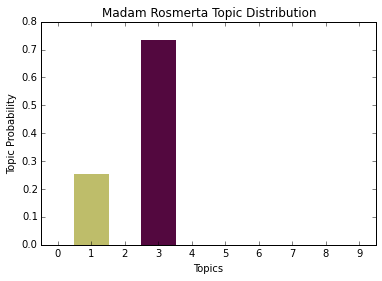

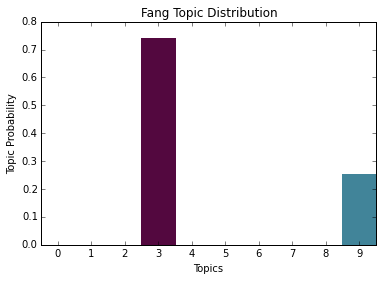

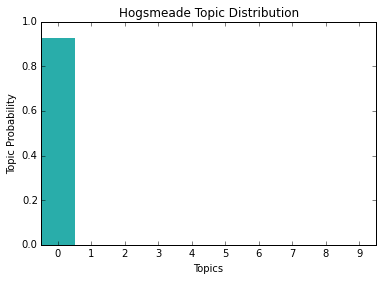

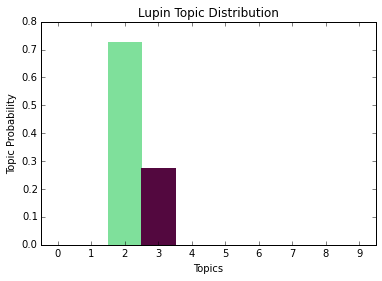

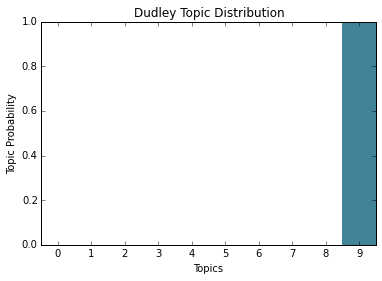

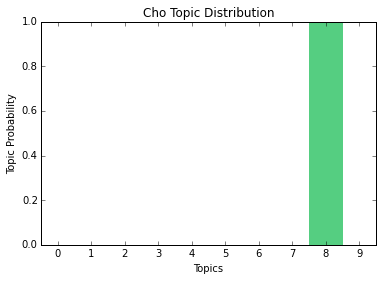

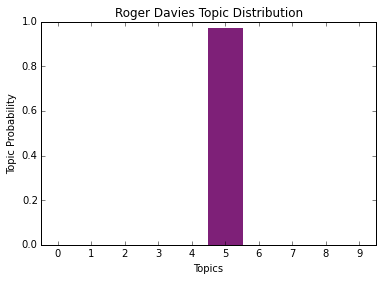

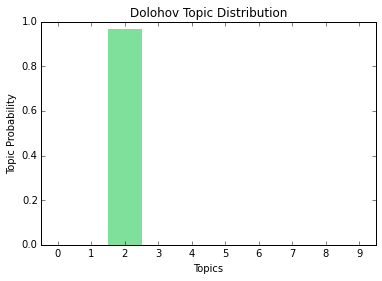

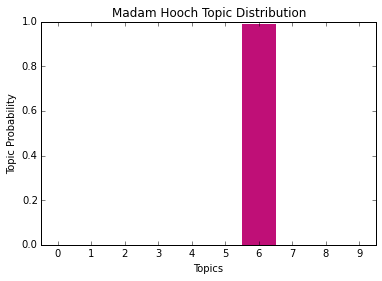

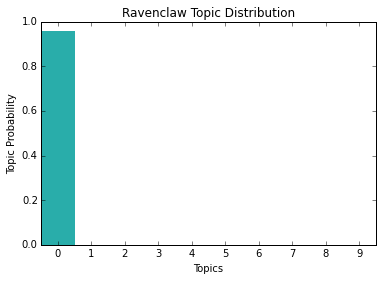

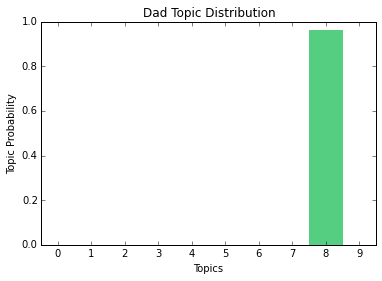

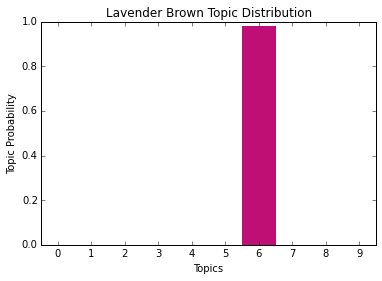

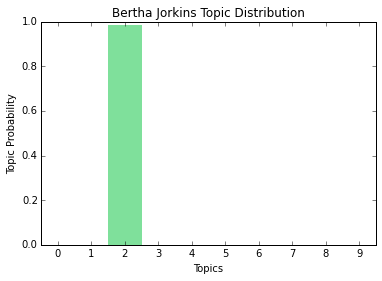

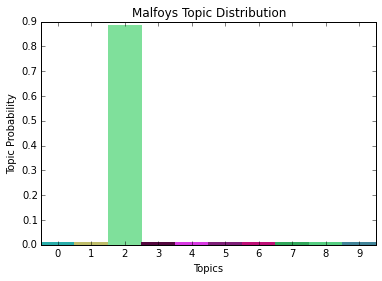

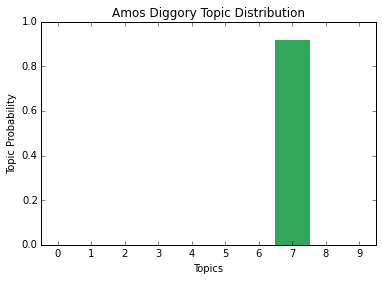

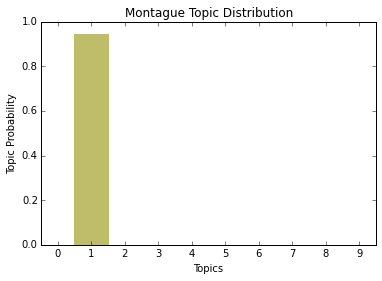

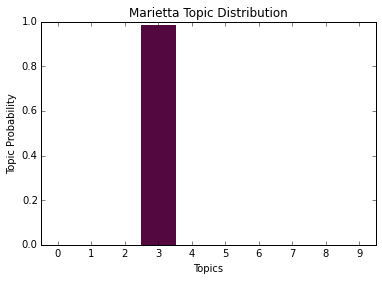

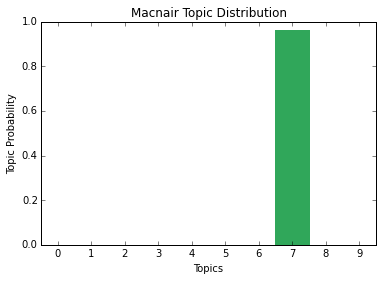

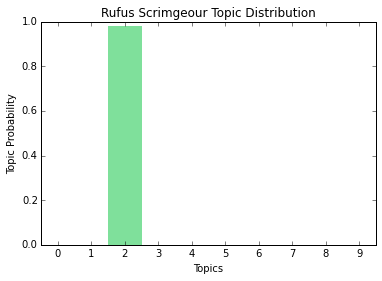

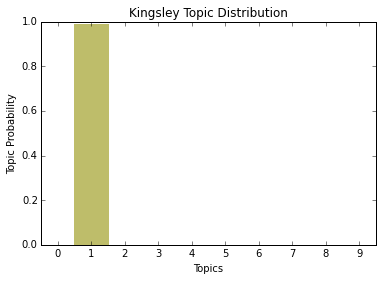

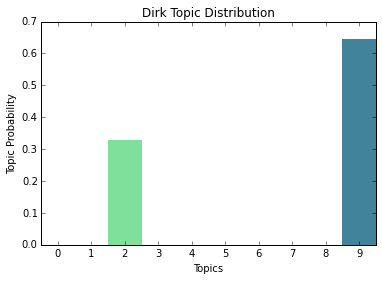

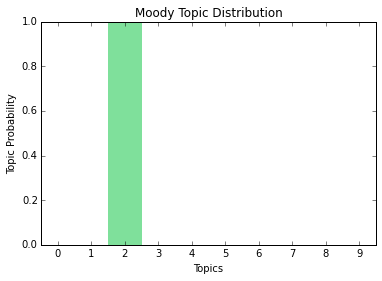

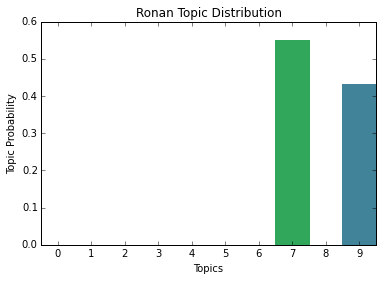

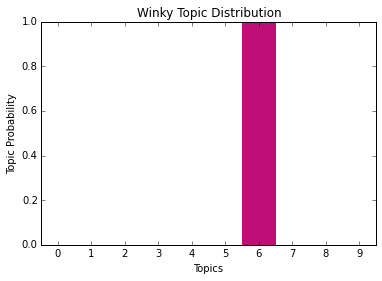

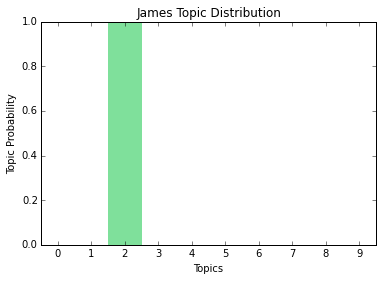

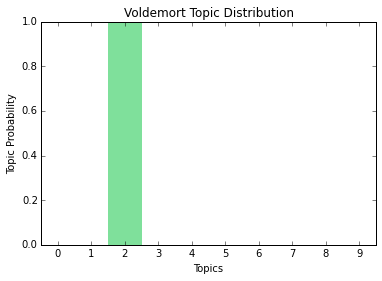

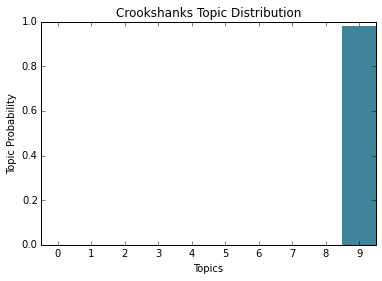

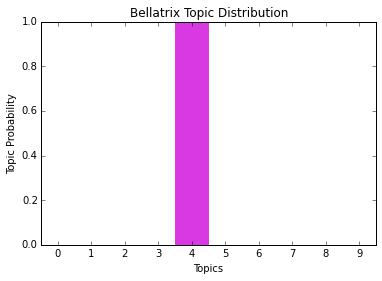

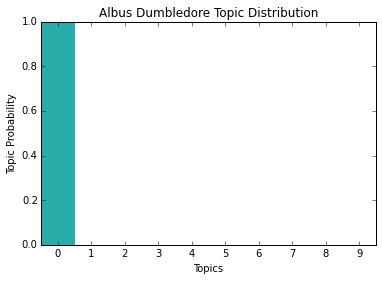

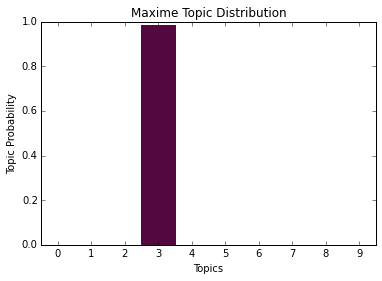

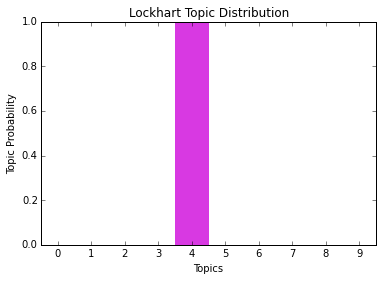

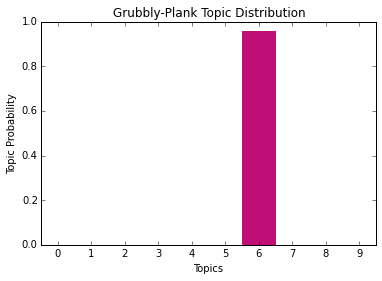

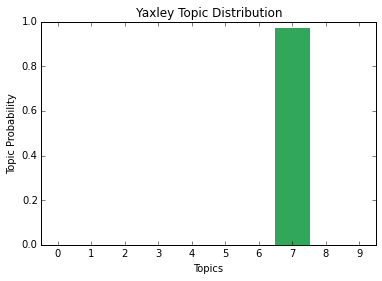

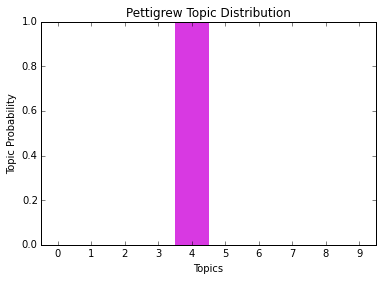

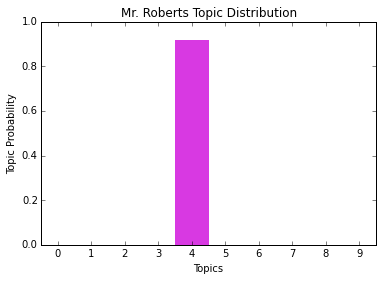

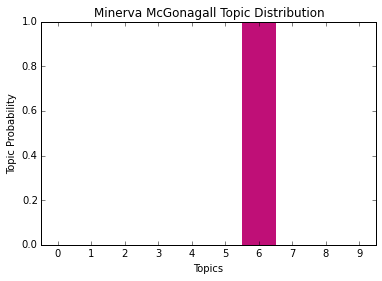

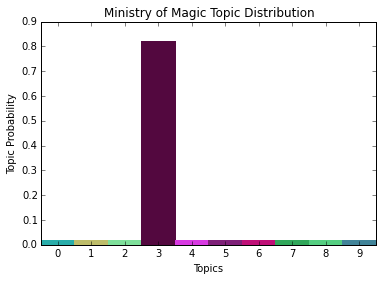

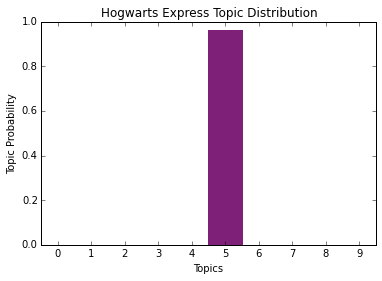

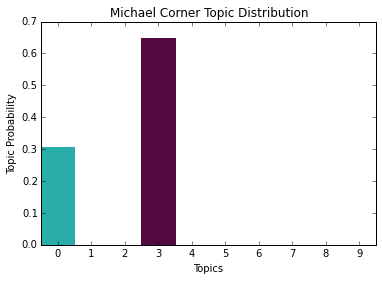

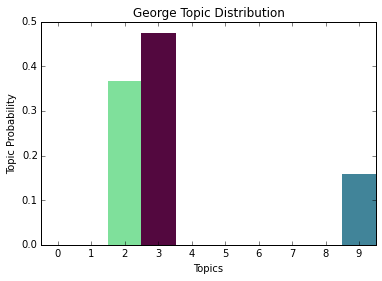

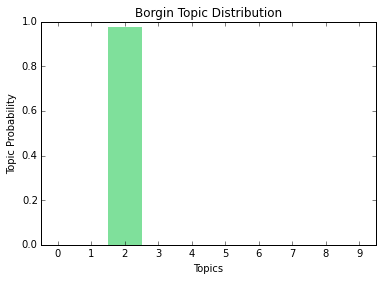

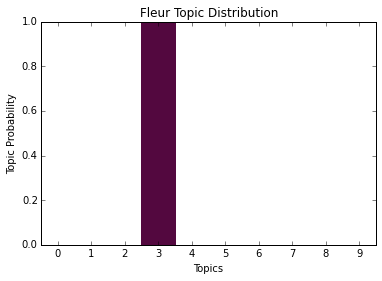

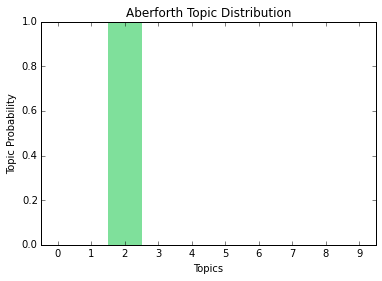

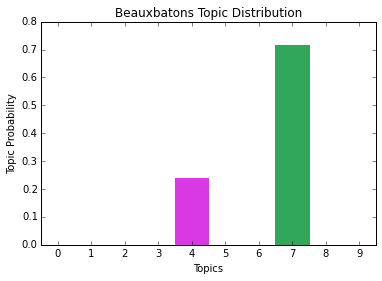

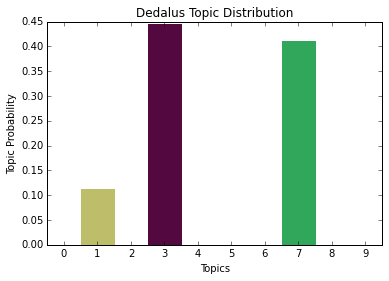

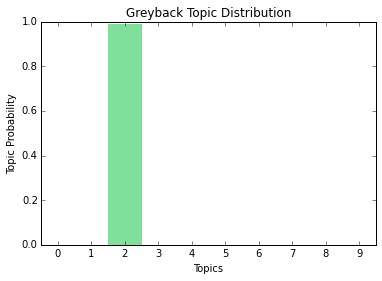

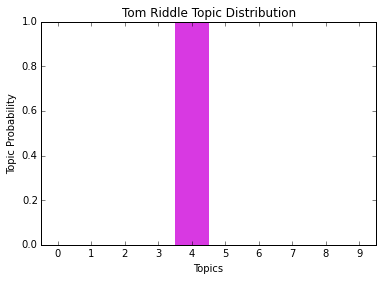

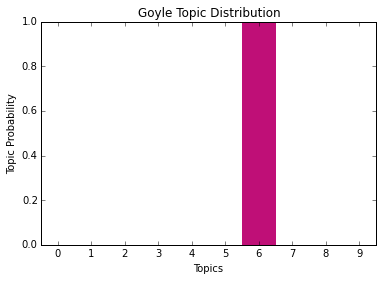

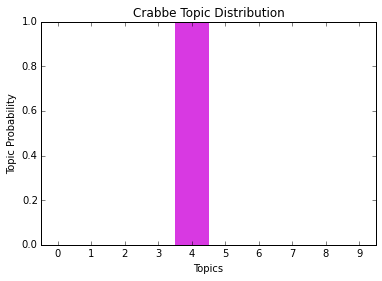

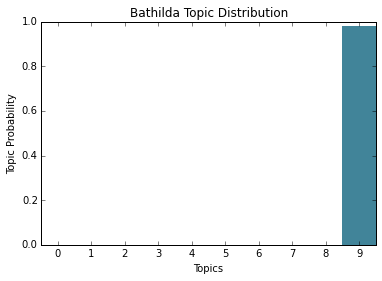

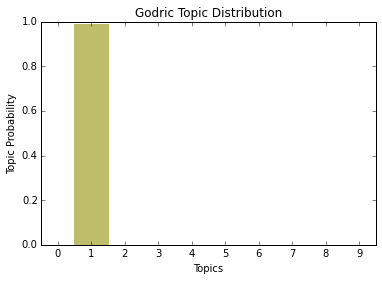

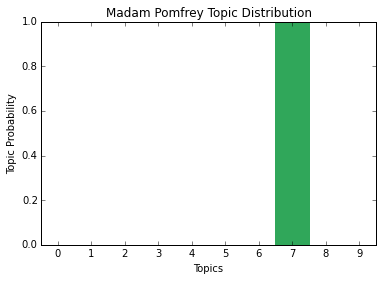

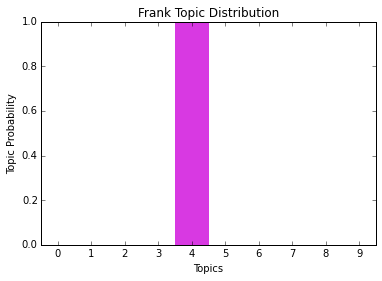

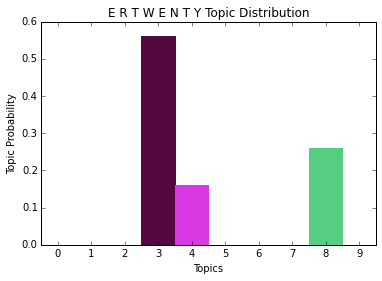

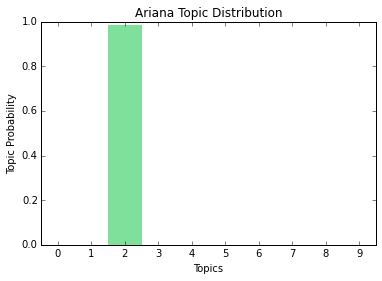

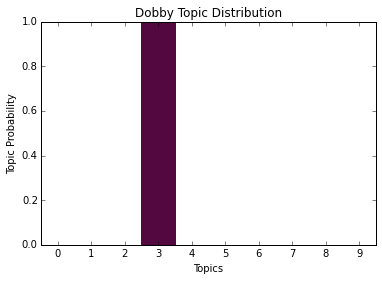

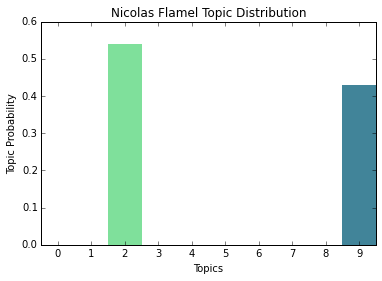

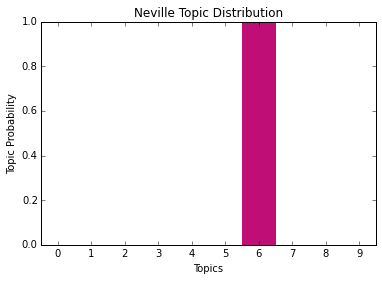

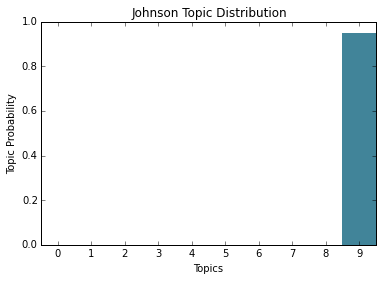

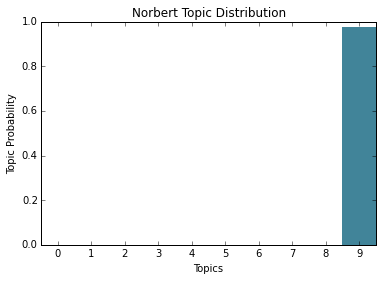

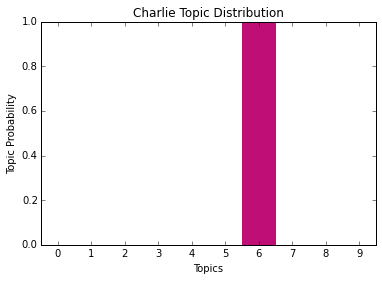

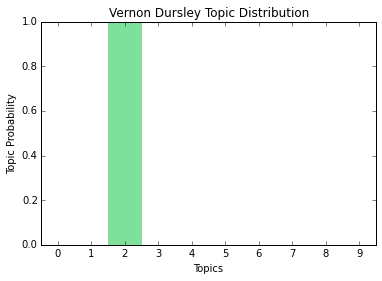

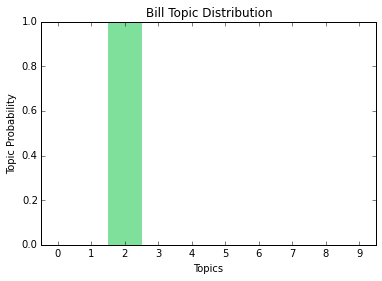

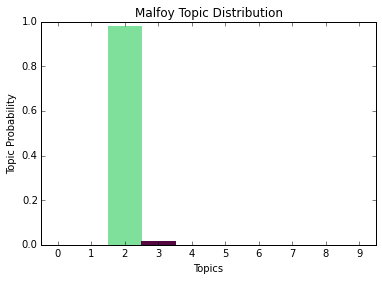

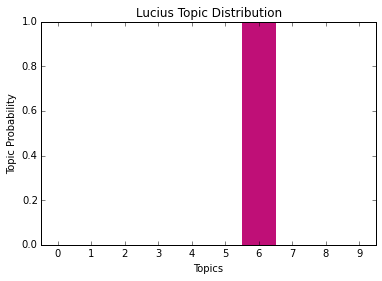

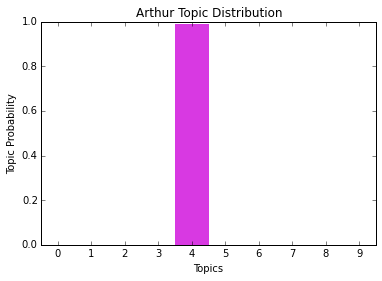

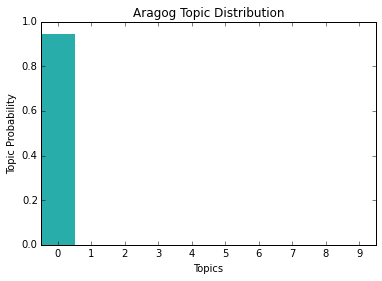

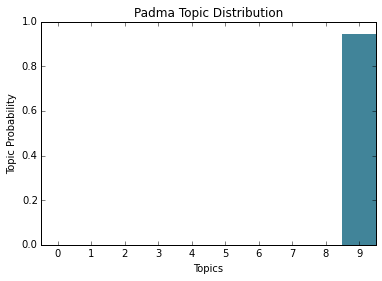

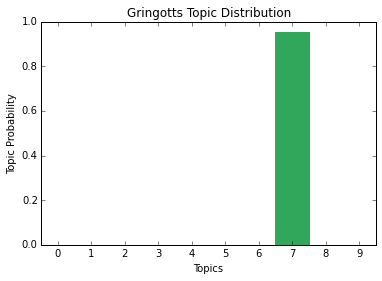

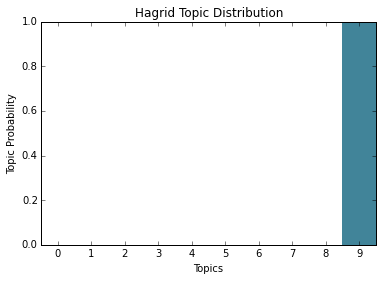

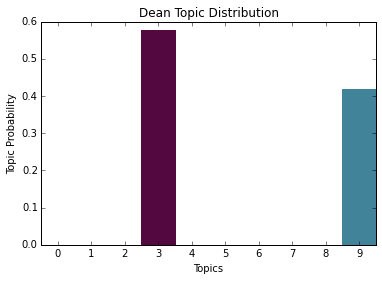

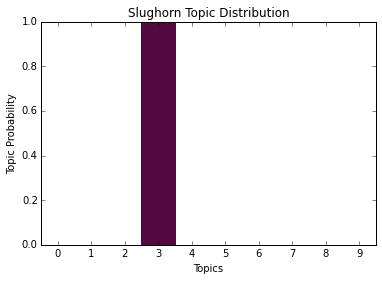

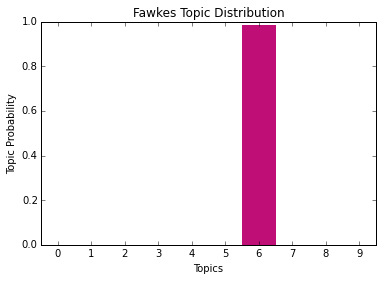

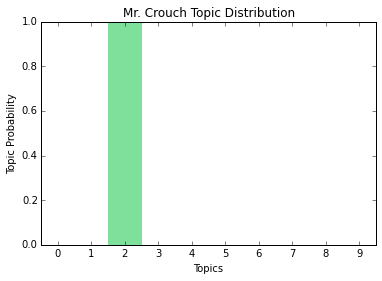

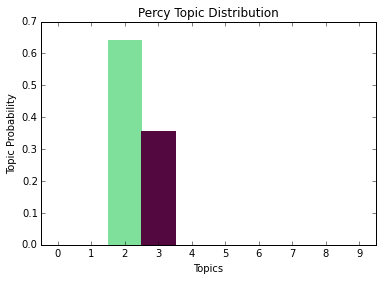

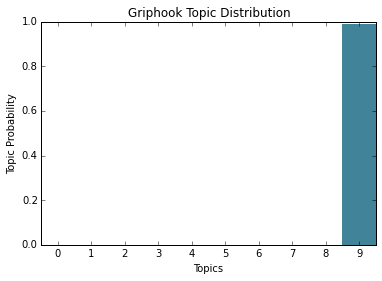

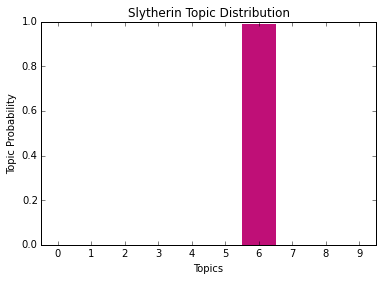

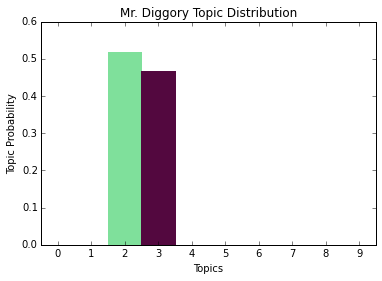

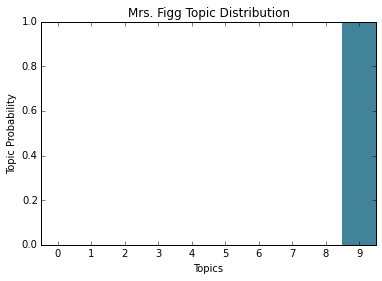

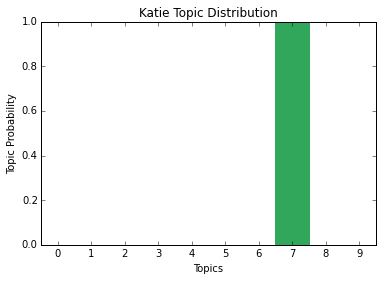

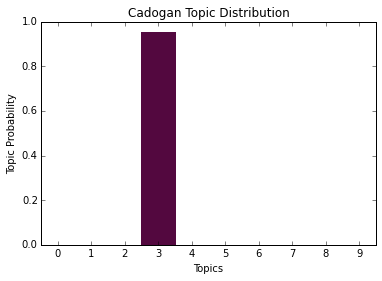

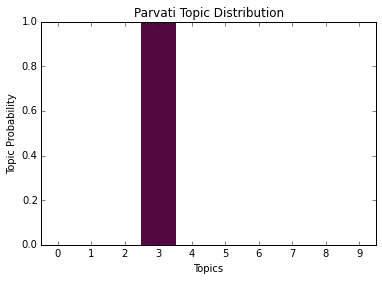

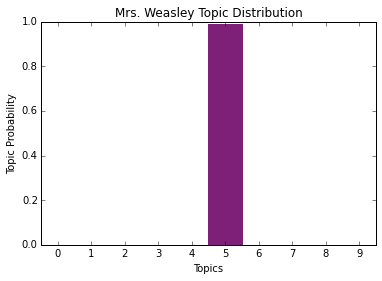

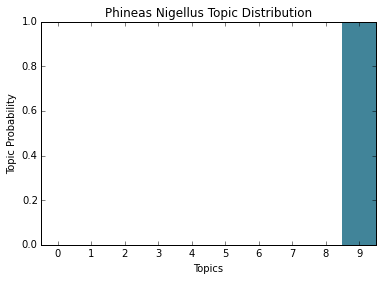

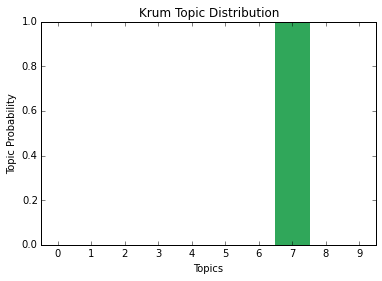

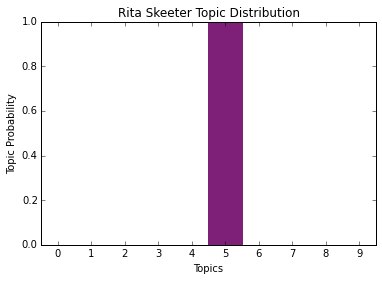

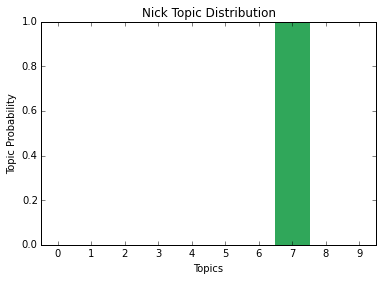

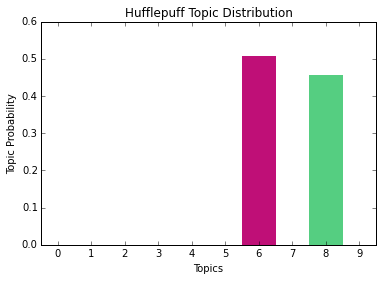

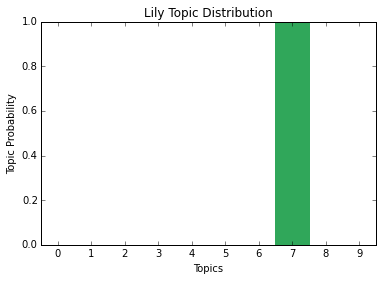

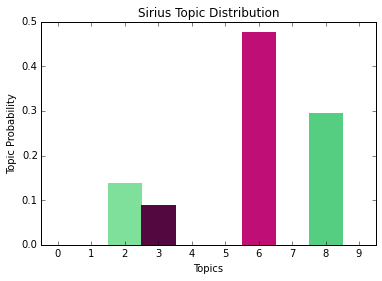

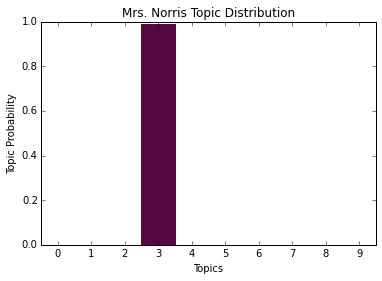

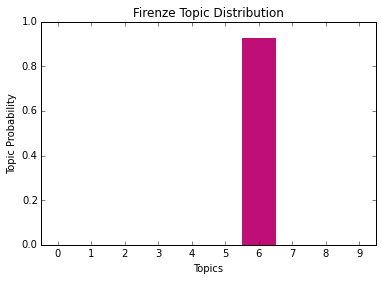

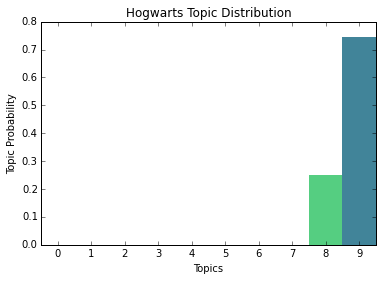

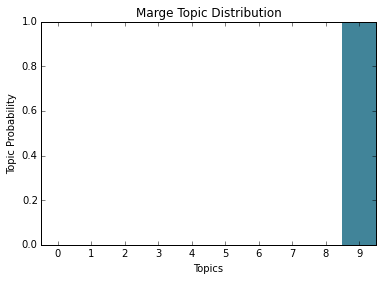

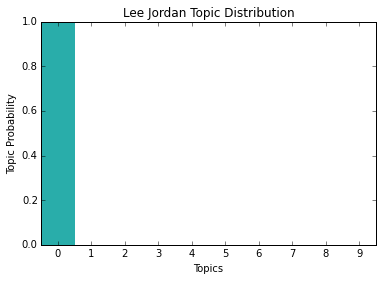

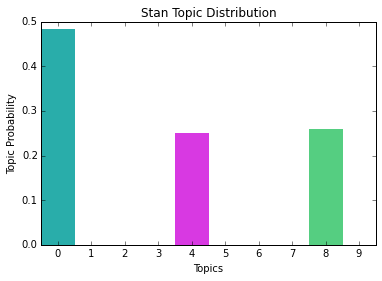

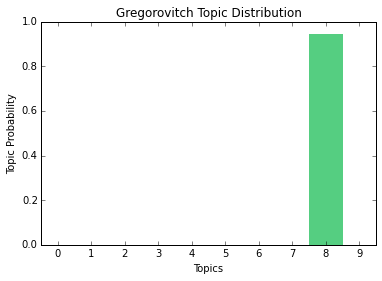

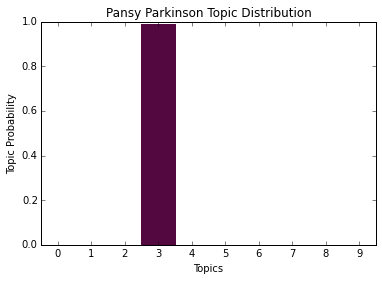

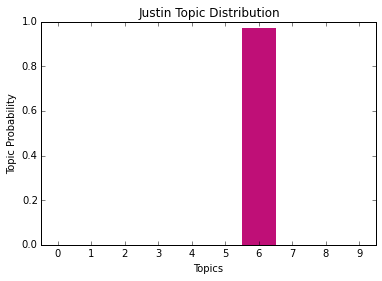

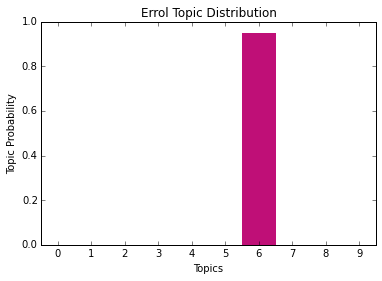

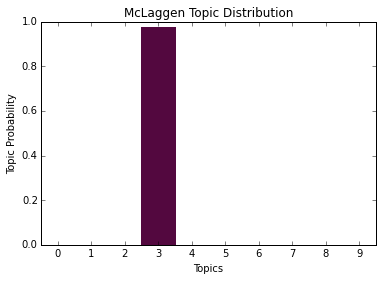

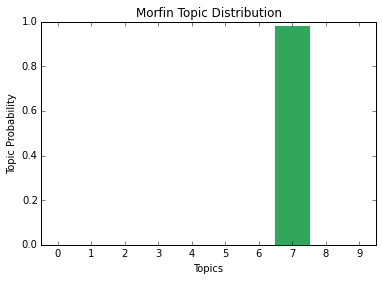

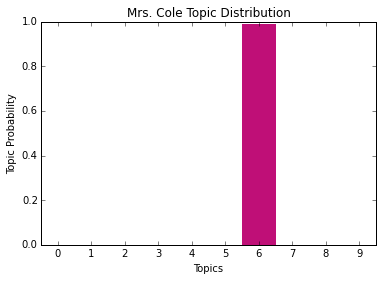

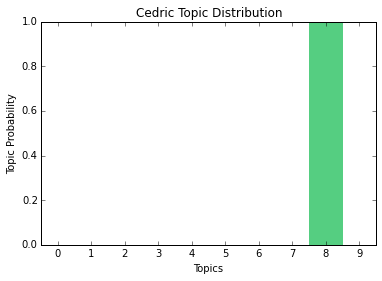

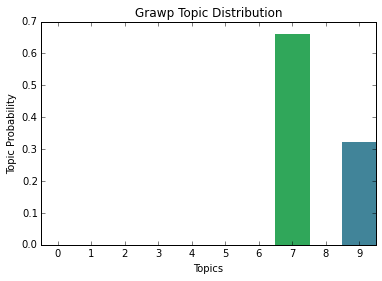

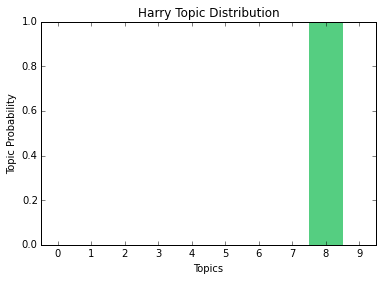

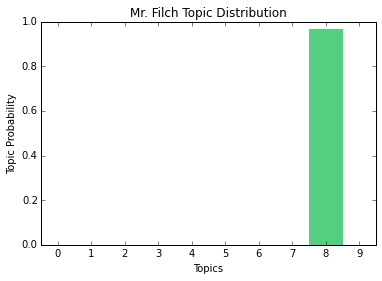

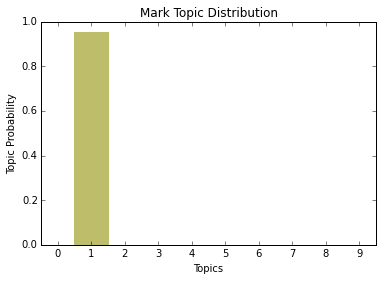

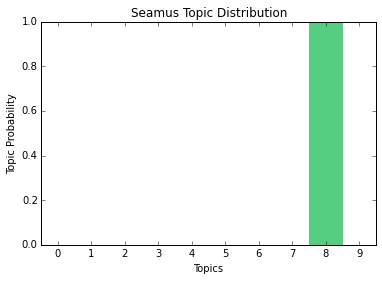

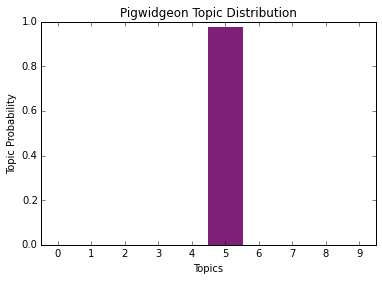

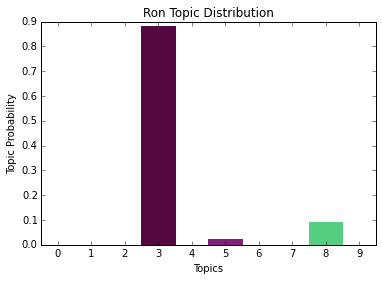

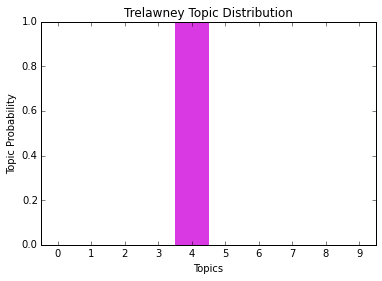

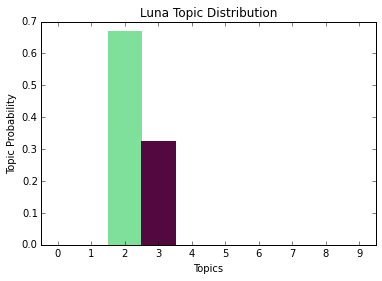

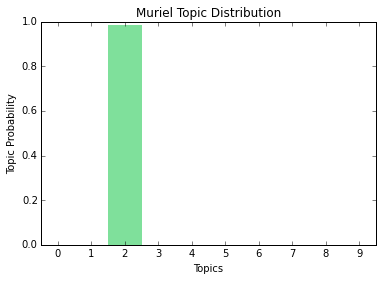

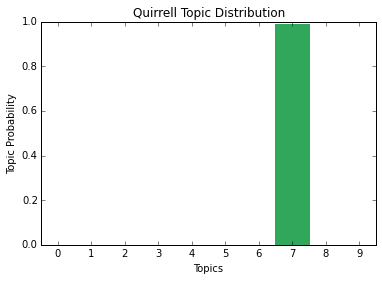

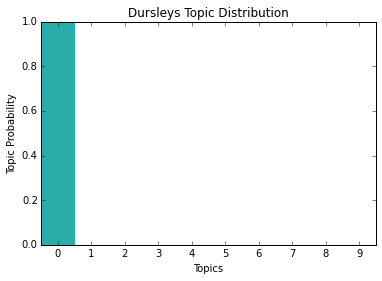

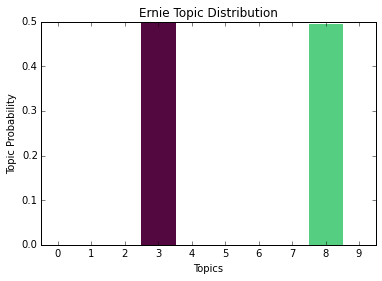

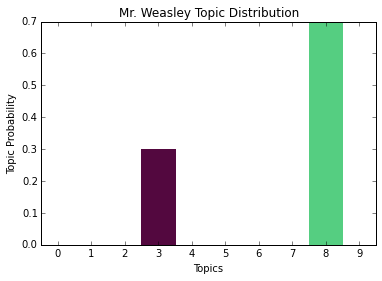

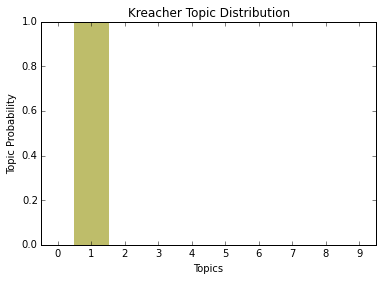

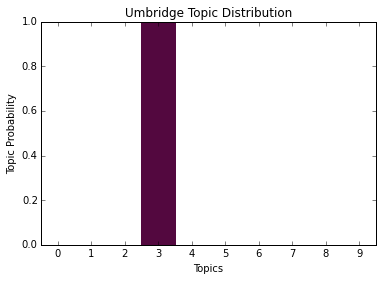

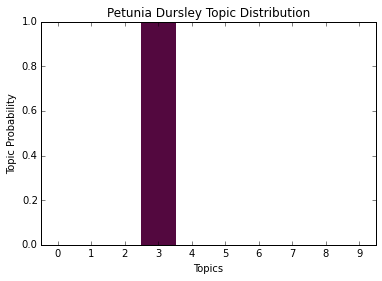

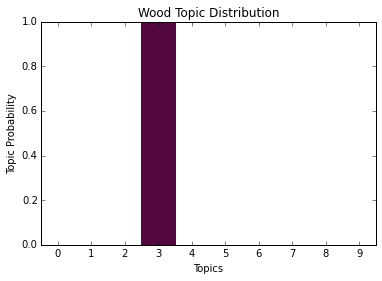

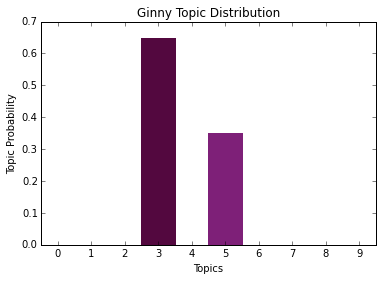

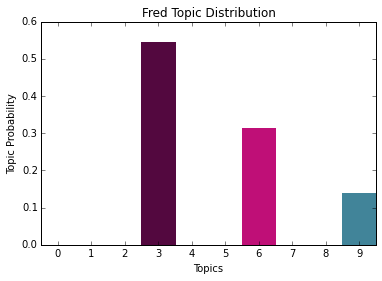

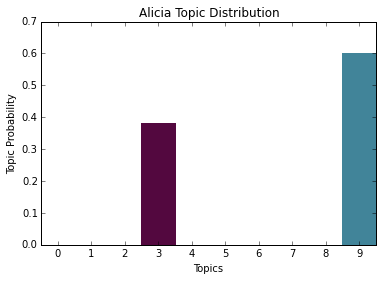

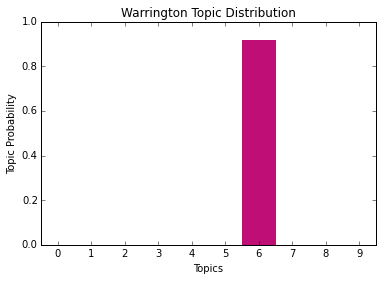

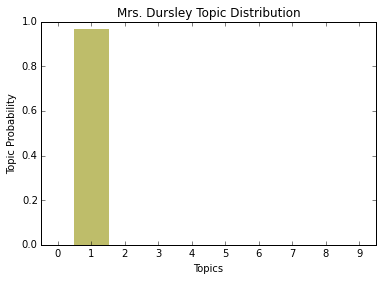

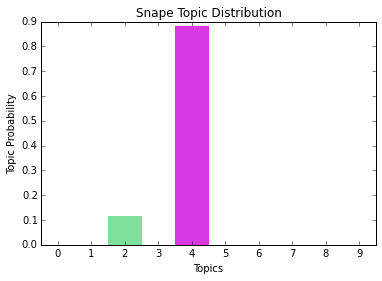

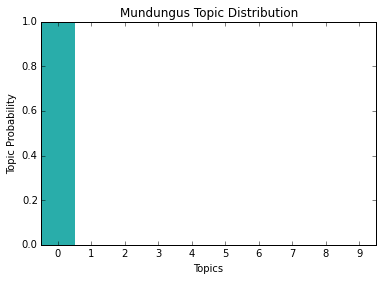

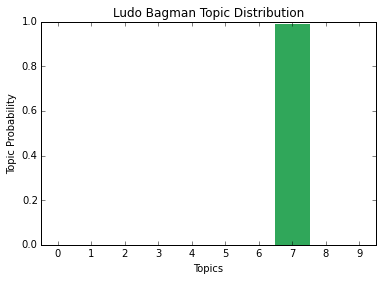

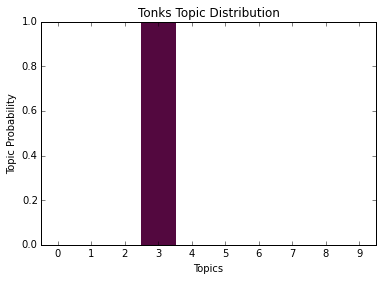

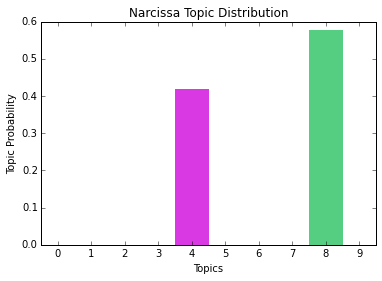

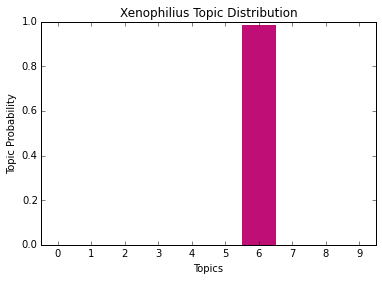

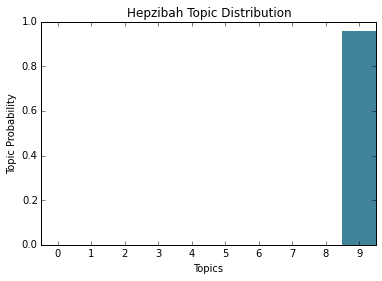

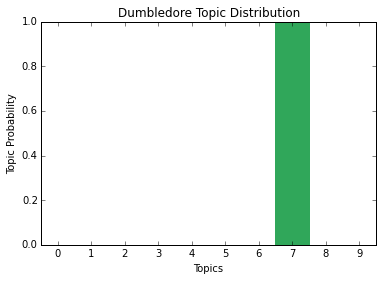

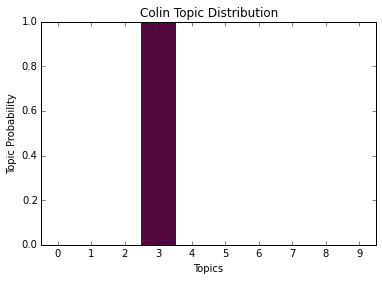

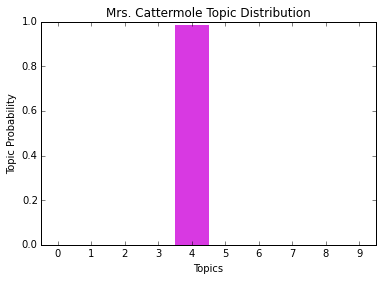

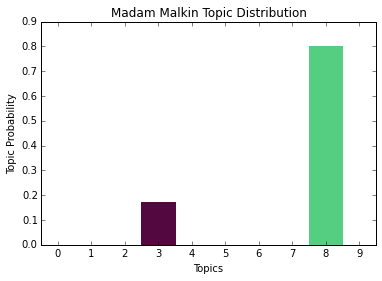

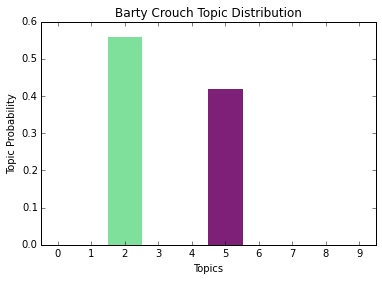

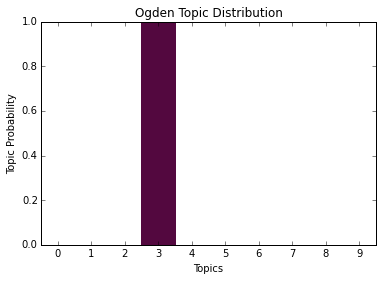

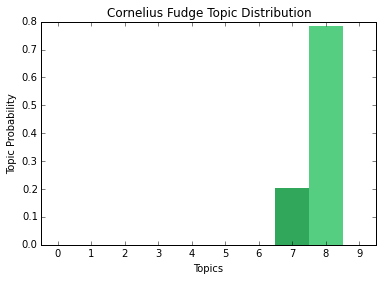

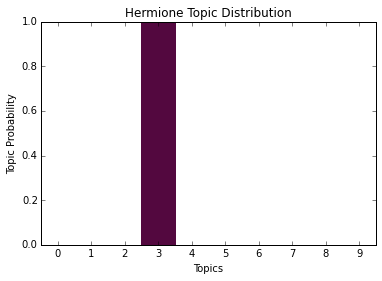

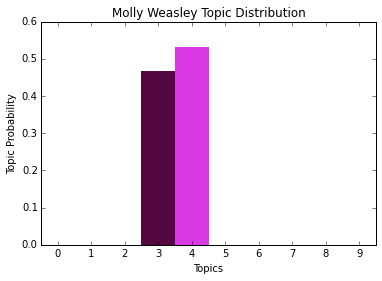

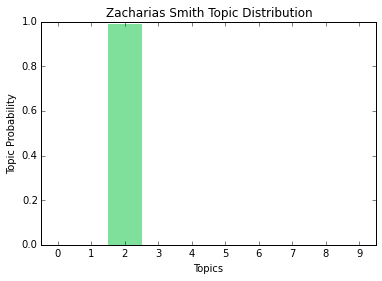

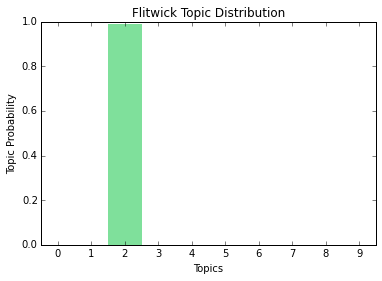

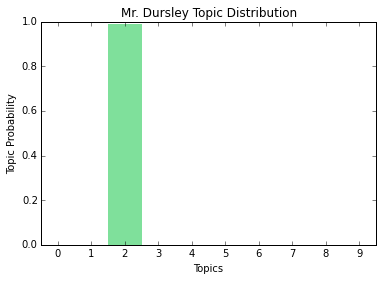

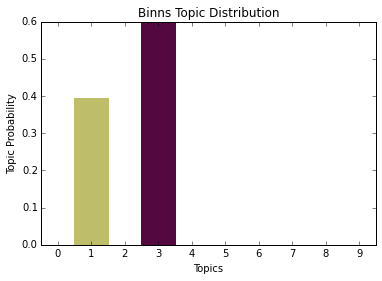

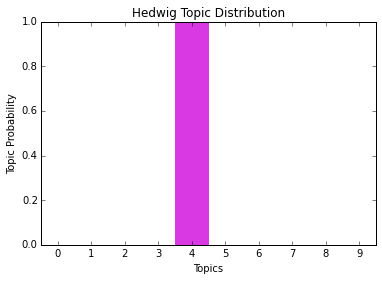

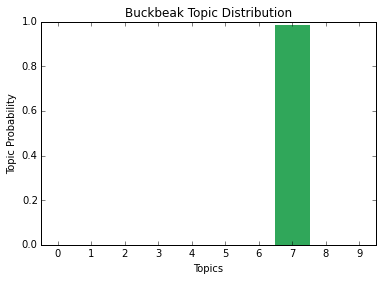

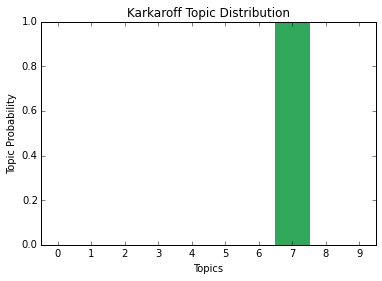

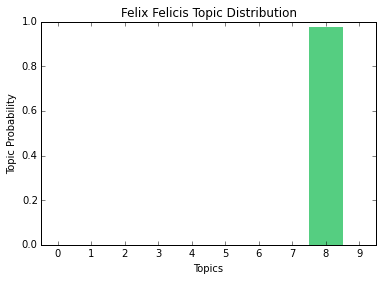

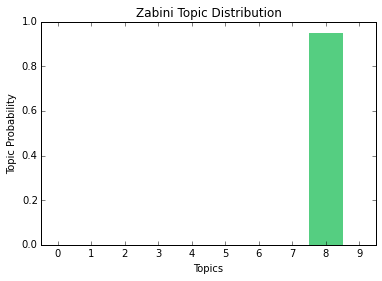

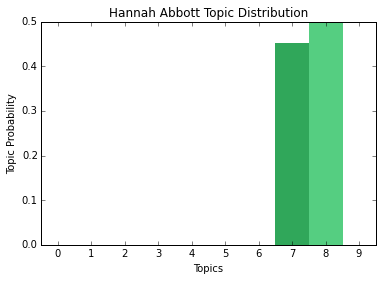

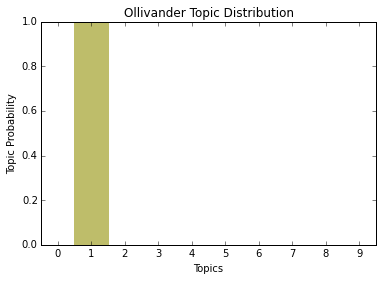

In [80]:
# TODO try to plot bar charts for each character
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

plots = []
%matplotlib inline 

nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the groups
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

#### Use KMeans (is this the best choice?) and print out the clusters list

In [81]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 3, 2, 2, 1, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 3, 1, 1, 1, 0, 1, 1, 2, 1, 2, 3, 1, 1, 3, 2, 2, 2, 3, 1, 1, 1, 0, 1, 1, 1, 3, 2, 2, 1, 3, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 0, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1]
silhouette score: 0.414244730254
inertia: 66.0617840332


#### Print out characters and cluster assignments (in order)

In [82]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Macnair', 0)
('Ronan', 0)
('Yaxley', 0)
('Beauxbatons', 0)
('Madam Pomfrey', 0)
('Gringotts', 0)
('Karkaroff', 0)
('Katie', 0)
('Krum', 0)
('Nick', 0)
('Lily', 0)
('Morfin', 0)
('Grawp', 0)
('Amos Diggory', 0)
('Quirrell', 0)
('Ludo Bagman', 0)
('Buckbeak', 0)
('Dumbledore', 0)
('Hannah Abbott', 0)
('Madam Rosmerta', 1)
('Fang', 1)
('Hogsmeade', 1)
('Dudley', 1)
('Cho', 1)
('Roger Davies', 1)
('Ravenclaw', 1)
('Dad', 1)
('Pigwidgeon', 1)
('Montague', 1)
('Marietta', 1)
('Kingsley', 1)
('Dirk', 1)
('Crookshanks', 1)
('Bellatrix', 1)
('Zabini', 1)
('Albus Dumbledore', 1)
('Maxime', 1)
('Lockhart', 1)
('Pettigrew', 1)
('Mr. Roberts', 1)
('Ministry of Magic', 1)
('Hogwarts Express', 1)
('Michael Corner', 1)
('George', 1)
('Fleur', 1)
('Tom Riddle', 1)
('Crabbe', 1)
('Bathilda', 1)
('Godric', 1)
('Frank', 1)
('E R T W E N T Y', 1)
('Johnson', 1)
('Norbert', 1)
('Arthur', 1)
('Aragog', 1)
('Padma', 1)
('Hagrid', 1)
('Dean', 1)
('Slughorn', 1)
('Griphook', 1)
('Mrs. Figg', 1)
('Cadogan', 1)

#### Create data frame for clusters and characters

In [83]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [84]:
frame['clusters'].value_counts() 

1    91
2    25
3    19
0    19
Name: clusters, dtype: int64

#### Show visual cluster plot (all this code is heavily derivative of that guy's tutorial)

In [85]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [86]:
# TODO: change so that this automatically works with any of number clusters
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

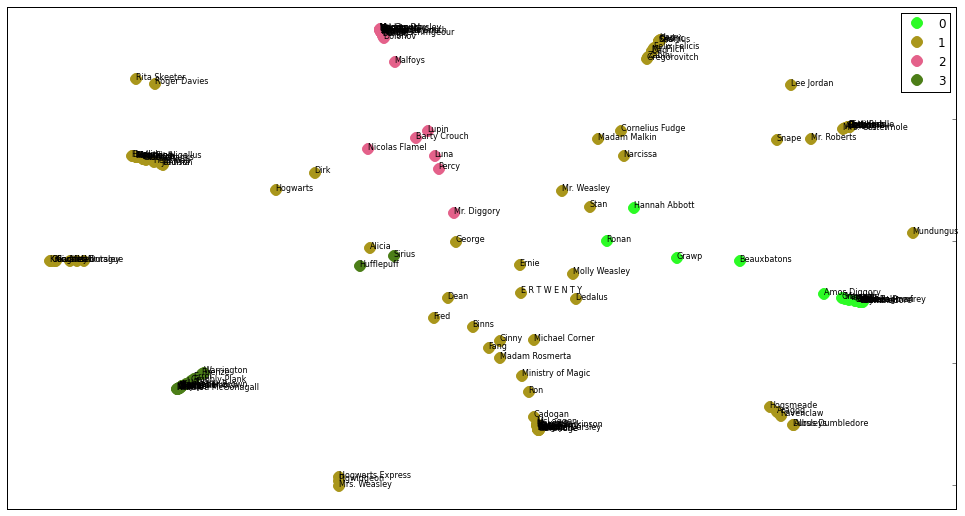

In [87]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [88]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters (again taken from the dude's tutorial)

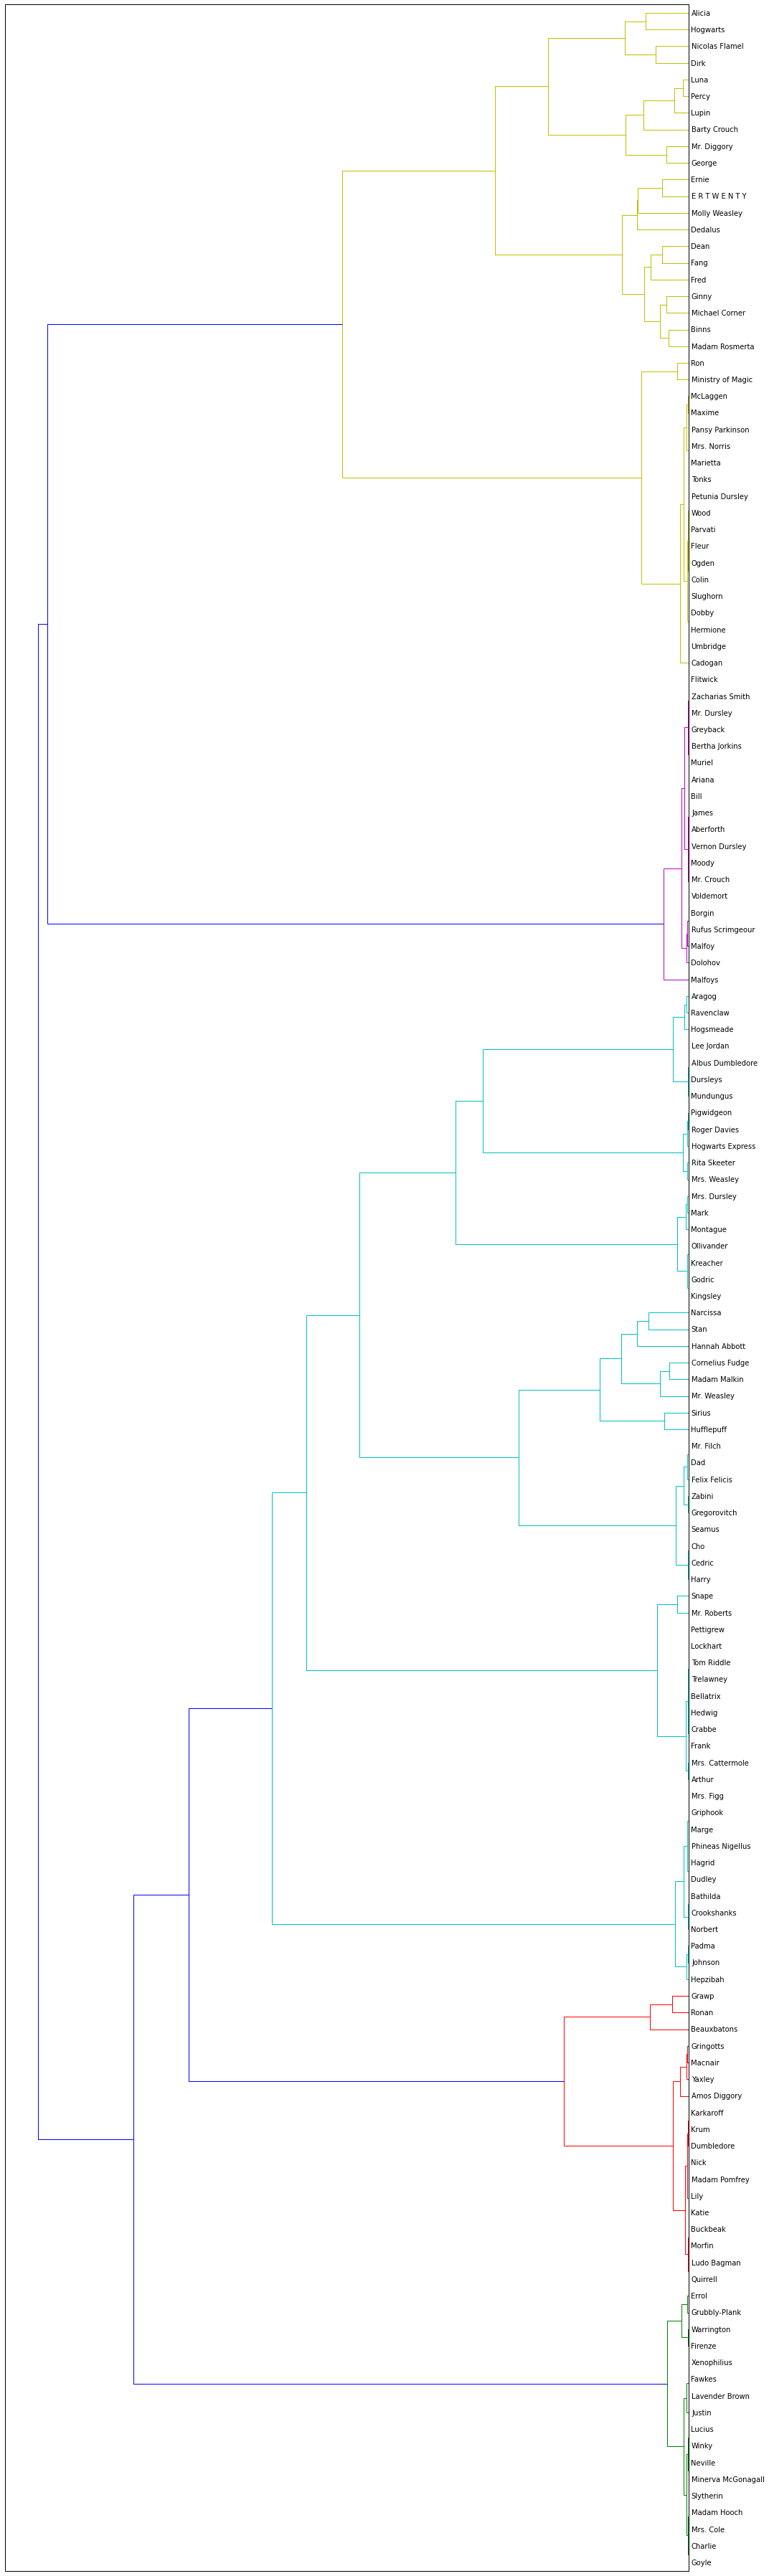

In [89]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [90]:
# load our labeled character data
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")

In [91]:
# shuffle our samples
combined = zip(charlist, vectors)
random.shuffle(combined)
charlist[:], vectors[:] = zip(*combined)

for i in range(len(vectors)):
    print charlist[i]
    print vectors[i]

Bellatrix Lestrange
[0, 1, 0, 0]
Madame Maxime
[0, 0, 1, 0]
Cornelius Fudge
[0, 1, 0, 0]
Hedwig
[0, 0, 0, 1]
Scabbers
[0, 0, 0, 1]
Warrington
[0, 0, 1, 0]
Aberforth
[0, 0, 1, 0]
Voldemort
[0, 1, 0, 0]
Winky
[0, 0, 1, 0]
Severus Snape
[0, 1, 0, 0]
Gregorovitch
[0, 0, 1, 0]
Fang
[0, 0, 0, 1]
Lupin
[1, 0, 0, 0]
Morfin
[0, 1, 0, 0]
Norbert
[0, 0, 0, 1]
Albus Dumbledore
[1, 0, 0, 0]
Roger Davies
[0, 0, 1, 0]
Aragog
[0, 0, 0, 1]
Alicia Spinnet
[0, 0, 1, 0]
Dennis Creevey
[0, 0, 1, 0]
Bathilda Bagshot
[0, 0, 1, 0]
Lavender Brown
[0, 0, 1, 0]
Zabini
[0, 0, 1, 0]
Mr. Roberts
[0, 0, 1, 0]
Travers
[0, 1, 0, 0]
Grawp
[0, 0, 0, 1]
Charlie Weasley
[0, 0, 1, 0]
Grubbly-Plank
[0, 0, 1, 0]
Goyle
[0, 1, 0, 0]
Pigwidgeon
[0, 0, 0, 1]
Rowena Ravenclaw
[0, 0, 1, 0]
Auntie Muriel
[0, 0, 1, 0]
Romilda Vane
[0, 0, 1, 0]
Hermione Granger
[1, 0, 0, 0]
Phineus Nigelus
[0, 1, 0, 0]
Madam Rosmerta
[0, 0, 1, 0]
Binns
[0, 0, 1, 0]
Dolores Umbridge
[0, 1, 0, 0]
Justin
[0, 0, 1, 0]
Crookshanks
[0, 0, 0, 1]
Mrs. Dursle

In [92]:
#print character_namelists.values()

In [93]:
# get a list of the indices for labeled characters that were recognized by book-nlp
labeled = []
i = 0
for name in charlist:
    found = False
    for namelist in character_namelists.values():
        if name.encode('UTF-8') in namelist:
            found = True
    if found:
        #print name.encode('UTF-8')
        labeled.append(i)
    #else:
        #print name.encode('UTF-8')
    i+=1
num_samples = len(labeled)

In [94]:
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for index in labeled:
    labeled_chars.append(charlist[index])
    matrix.append(vectors[index])
    labeled_topic_matrix.append(topic_matrix[index])

labeled_topic_matrix = np.array(labeled_topic_matrix) 
print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
print labelmatrix
#transpose_labels = labelmatrix.transpose()

    

[[ 0.          0.254752    0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.25267434]
 [ 0.92499421  0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.98915483 ...,  0.          0.          0.        ]]
[[0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 

In [95]:
from sklearn import linear_model

# choose the appropriate row to get your labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles
print labelmatrix[0].size
for label in range(labelmatrix[0].size):
    print labels[label]
    half = (int)(num_samples/2)
    labelTrain = labelmatrix[0:half, label]
    labelTest = labelmatrix[half:num_samples, label]
    print labelTrain.ravel()
    print labelTest.ravel()
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    # print labeled_topic_matrix[0:half,:]
    logreg.fit(labeled_topic_matrix[0:half,:], labelTrain)
    Z = logreg.predict(labeled_topic_matrix[half:num_samples,:])
    print "accuracy: ", logreg.score(labeled_topic_matrix[half:num_samples,:], labelTest)
    # print Z
    for i in range(len(Z)):
        if Z[i] == 1:
            print labeled_chars[half+i]
    print
   

4
Protagonists
[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1]]
[[1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0
  1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]]
accuracy:  0.666666666667
Madam Malkin
Minerva McGonagall
Narcissa Malfoy
Stan Shunpike
Angelina Johnson
Cedric
Padma Patil
Mundungus Fletcher
Peter Pettigrew
Frank Bryce

Antagonists
[[1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0
  0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0]]
[[0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]]
accuracy:  0.757575757576
Yaxley
Lee Jordan
Fawkes

Neutral
[[0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1
  0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0]]
[[0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1

C:\Users\Molly\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Molly\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Molly\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Molly\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 